In [1]:
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style for consistent, theme-friendly figures
plt.style.use('../pathsim_docs.mplstyle')

In [3]:
import numpy as np

def f(a, b, c):
    return (a**2 - b) * np.cos(c)

Lets start by evaluating our function with some regular floats:

In [6]:
#inputs are just regular floats
x, y, z = 1.1, 3.5, 2.0

w = f(x, y, z)

print(w) #0.9529762556929561

0.9529762556929561


In [8]:
from pathsim.optim import Value

#inputs are Value instances
x, y, z = Value.array([1.1, 3.5, 2.0])

w = f(x, y, z)

print(w) #Value(val=0.9529762556929561, grad=defaultdict(<class 'float'>, {2565427398528: np.float64(-0.9155230404037134), 2565426875648: np.float64(0.4161468365471424), 2565403265920: np.float64(2.082291107430811)}))

Value(val=0.9529762556929561, grad=defaultdict(<class 'float'>, {2139162399936: -0.9155230404037134, 2139193669568: 0.4161468365471424, 2139170484416: 2.082291107430811}))


In [10]:
dw_dx = w(x)
dw_dy = w(y)
dw_dz = w(z)

print(dw_dx) #-0.9155230404037134
print(dw_dy) #0.4161468365471424
print(dw_dz) #2.082291107430811

-0.9155230404037134
0.4161468365471424
2.082291107430811


In [12]:
dw_dx = Value.der(w, x)
dw_dy = Value.der(w, y)
dw_dz = Value.der(w, z)

2025-10-10 13:55:11,908 - INFO - LOGGING (log: True)
2025-10-10 13:55:11,908 - INFO - BLOCK (type: Source, dynamic: False, events: 0)
2025-10-10 13:55:11,909 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-10-10 13:55:11,909 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-10-10 13:55:11,909 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-10-10 13:55:11,910 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-10 13:55:11,910 - INFO - GRAPH (size: 5, alg. depth: 3, loop depth: 0, runtime: 0.077ms)
2025-10-10 13:55:11,911 - INFO - STARTING -> TRANSIENT (Duration: 12.00s)
2025-10-10 13:55:11,911 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-10 13:55:11,928 - INFO - TRANSIENT:  20% | elapsed: 00:00:00 (eta: --:--:--) | 241 steps (13330.9 steps/s)
2025-10-10 13:55:11,947 - INFO - TRANSIENT:  40% | elapsed: 00:00:00 (eta: --:--:--) | 481 steps (13263.5 steps/s)
2025-10-10 13:55:11,966 - IN

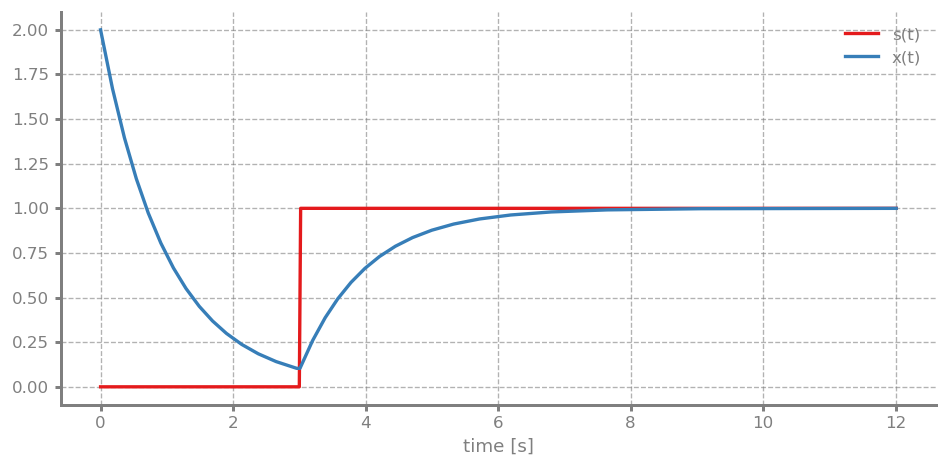

(<Figure size 960x480 with 1 Axes>, <Axes: xlabel='time [s]'>)

In [14]:
from pathsim import Simulation, Connection
from pathsim.blocks import Source, Integrator, Amplifier, Adder, Scope

#AD framework
from pathsim.optim import Value

#step delay
tau = 3

#parameters for AD and standard deviations (the only difference to regular simulation setup)
a  = Value(-1, sig=0.1)
s  = Value(1, sig=0.05)
x0 = Value(2, sig=0.5)

#step function with delay
def step(t):
    return s*float(t>tau)

#blocks defining the system
src = Source(step)
itg = Integrator(x0)
amp = Amplifier(a)
add = Adder()
sco = Scope(labels=["s(t)", "x(t)"])

#initialize simulation
sim = Simulation(
    blocks=[src, itg, amp, add, sco],
    connections=[
        Connection(src, add[0], sco[0]),
        Connection(amp, add[1]),
        Connection(add, itg),
        Connection(itg, amp, sco[1])
    ], dt=0.01)

#run simulation for some time
sim.run(4*tau)

#plot the results
sco.plot()

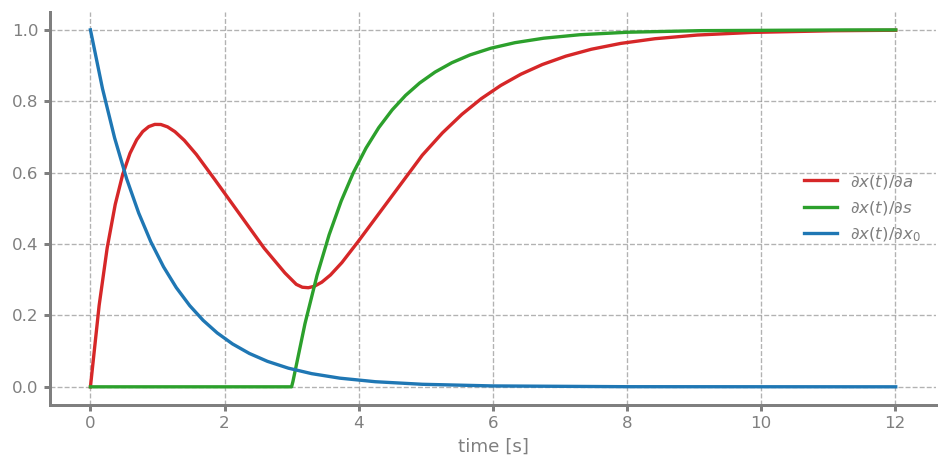

In [16]:
import matplotlib.pyplot as plt

#get the simulation results
time, [_, x] = sco.read()

#extract the sensitivities
dx_da = Value.der(x, a)
dx_ds = Value.der(x, s)
dx_dx0 = Value.der(x, x0)

#plot sensitivities
fig, ax = plt.subplots(nrows=1, figsize=(8, 4), tight_layout=True, dpi=120)

ax.plot(time, dx_da, lw=2, c="tab:red", label=r"$\partial x(t)/ \partial a$")
ax.plot(time, dx_ds, lw=2, c="tab:green", label=r"$\partial x(t)/\partial s$")
ax.plot(time, dx_dx0, lw=2, c="tab:blue", label=r"$\partial x(t)/\partial x_0$")

ax.set_xlabel("time [s]")
ax.grid(True)
ax.legend()

plt.show()

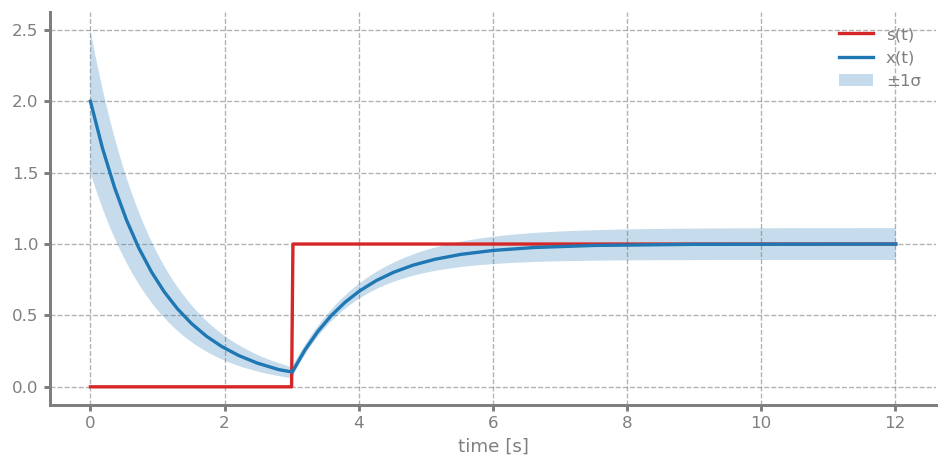

In [18]:
#extract output variance at each time point
var_x = Value.var(x, [a, s, x0])

#standard deviation bounds
x_upper = Value.numeric(x) + np.sqrt(var_x)
x_lower = Value.numeric(x) - np.sqrt(var_x)

#plot with uncertainty bounds
time, [stp, _] = sco.read()

fig, ax = plt.subplots(nrows=1, figsize=(8, 4), tight_layout=True, dpi=120)

ax.plot(time, stp, lw=2, c="tab:red", label="s(t)")
ax.plot(time, x, lw=2, c="tab:blue", label="x(t)")
ax.fill_between(time, x_lower, x_upper, color="tab:blue", alpha=0.25, label='±1σ', ec=None)
ax.set_xlabel('time [s]')
ax.legend()
ax.grid(True)

plt.show()